In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sqlfunctions import get_datapunten_voor_model
import pickle

## Notities
Datapunten AI:
- omzet
- Beursgenoteerd of niet
- sector (nacebel code)
- aantal personeelsleden
- hoofdsteden provincies

In [70]:
def get_initial_dataframe():
    data = get_datapunten_voor_model()
    dataframe = pd.DataFrame(data, columns=['ondernemingnr', 'omzet' ,'beursgenoteerd', 'sector', 'personeelsleden', 'site_aanwezig', 'pdf_aanwezig', 'score'])
    dataframe = dataframe.groupby('ondernemingnr').agg({'omzet': 'first', 'beursgenoteerd': 'first', 'sector': 'first', 'personeelsleden': 'first', 'site_aanwezig': 'first', 'pdf_aanwezig': 'first', 'score': 'sum'}).reset_index()
    dataframe.drop("ondernemingnr", axis=1, inplace=True)
    return dataframe

In [71]:
dataframe = get_initial_dataframe()

In [53]:
print(dataframe["site_aanwezig"].value_counts())
print(dataframe["pdf_aanwezig"].value_counts())
# rows that both have a site and a pdf
len(dataframe[(dataframe['site_aanwezig'] == 1) & (dataframe['pdf_aanwezig'] == 1)])

1    9017
0    3985
Name: site_aanwezig, dtype: int64
1    12475
0      527
Name: pdf_aanwezig, dtype: int64


8490

In [38]:
dataframe.info()
dataframe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   omzet            13002 non-null  float64
 1   beursgenoteerd   13002 non-null  bool   
 2   sector           13002 non-null  object 
 3   personeelsleden  13002 non-null  float64
 4   site_aanwezig    13002 non-null  int64  
 5   pdf_aanwezig     13002 non-null  int64  
 6   score            13002 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(1)
memory usage: 622.3+ KB


,omzet,personeelsleden,site_aanwezig,pdf_aanwezig,score
count,1.300200e+04,13002.000000,13002.000000,13002.000000,13002.000000
mean,1.057262e+07,37.731426,0.693509,0.959468,0.015781
std,1.922597e+07,38.205757,0.461054,0.197211,0.036343
min,0.000000e+00,3.000000,0.000000,0.000000,0.000000
25%,1.321987e+06,15.000000,0.000000,1.000000,0.002953
50%,2.724050e+06,24.000000,1.000000,1.000000,0.006690
75%,1.296500e+07,43.000000,1.000000,1.000000,0.015106
max,6.038329e+08,345.000000,1.000000,1.000000,0.631949


In [78]:
# Data Transformation Pipeline
from sklearn.pipeline import Pipeline
# Data die ik ga krijgen van API= [123412 (int, omzet), 300 (int, personeel), 9800 (int, postcode)!gebruik ik niet, nacbelcode (int, sector), 1 (boolean, jaarrekening), 1 (boolean, pdf),0 (boolean, beursgenoteerd)]
# first row of X_test
def transform_data(data):
    # TODO: we hebben originele data nodig om nieuwe data te transformeren
    data["sector"] = data["sector"].astype('category')
    ordinal_encoder = OrdinalEncoder()
    data["sector"] = ordinal_encoder.fit_transform(data[["sector"]])
    data["beursgenoteerd"] = data["beursgenoteerd"].astype('category')
    data["pdf_aanwezig"] = data["pdf_aanwezig"].astype('category')
    data["site_aanwezig"] = data["site_aanwezig"].astype('category')
    min_max_scaler = MinMaxScaler()
    data["omzet"] = min_max_scaler.fit_transform(data[["omzet"]])
    data["personeelsleden"] = min_max_scaler.fit_transform(data[["personeelsleden"]])
    data["personeelsleden"] = data["personeelsleden"].astype('float')
    

    return data


# api_data = [123412, 300, 9800, 12345, 1, 1, 0]
# dataframe = pd.DataFrame(data, columns=['omzet', 'beursgenoteerd', 'sector', 'personeelsleden', 'site_aanwezig', 'pdf_aanwezig', 'score'])
test_ = transform_data(dataframe)
    # Pipeline([
    #     ('ordinal_encoder', OrdinalEncoder()),

with open("final_model.sav", "rb") as file:
    model = pickle.load(file)
    
test_ = test_.drop("score", axis=1)
test_ = test_.iloc[-1:]
model.predict(test_)

array([0.01373085])

In [67]:
# categorize sector
dataframe["sector"] = dataframe["sector"].astype('category')
# get amount of different sectors
sectors = dataframe["sector"].cat.categories
# how are the sectors distributed ?
dataframe["sector"].value_counts()

Goederenvervoer over de weg, m.u.v. verhuisbedrijven                             522
Detailhandel in auto's en lichte bestelwagens (kleiner of gelijk aan 3,5 ton)    342
Ontwerpen en programmeren van computerprogramma's                                288
Algemene bouw van residentiële gebouwen                                          257
Schrijnwerk                                                                      234
                                                                                ... 
Schilderen van civieltechnische werken                                             1
Vervaardiging van keramische tegels en plavuizen                                   1
Schoonheidsverzorging                                                              1
Vervaardiging van kantoorbenodigdheden van papier                                  1
Groothandel in levende dieren, m.u.v. levend vee                                   1
Name: sector, Length: 743, dtype: int64

In [75]:
# Data preprocessing


# encode sector
ordinal_encoder = OrdinalEncoder()
dataframe["sector"] = ordinal_encoder.fit_transform(dataframe[["sector"]])
dataframe["sector"] = dataframe["sector"].astype('category')
dataframe["beursgenoteerd"] = ordinal_encoder.fit_transform(dataframe[["beursgenoteerd"]])
dataframe["beursgenoteerd"] = dataframe["beursgenoteerd"].astype('category')
dataframe["site_aanwezig"] = dataframe["site_aanwezig"].astype('category')
dataframe["pdf_aanwezig"] = dataframe["pdf_aanwezig"].astype('category')

# Min Max scaling the omzet and personeelsleden
dataframe["omzet"] = MinMaxScaler().fit_transform(dataframe[["omzet"]])
dataframe["personeelsleden"] = MinMaxScaler().fit_transform(dataframe[["personeelsleden"]])
dataframe["personeelsleden"] = dataframe["personeelsleden"].astype(float)


In [69]:
dataframe

,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,score
0,0.021860,0.0,378.0,0.070175,1,1,0.131380
1,0.029976,1.0,378.0,0.175439,1,1,0.013276
2,0.015178,0.0,13.0,0.438596,0,1,0.003428
3,0.014047,0.0,377.0,0.128655,1,1,0.043966
4,0.025320,0.0,378.0,0.242690,1,1,0.107927
...,...,...,...,...,...,...,...
12997,0.001454,0.0,99.0,0.020468,0,1,0.002817
12998,0.000000,0.0,496.0,0.143275,1,0,0.004862
12999,0.056761,0.0,556.0,0.058480,0,1,0.005119
13000,0.009226,0.0,373.0,0.078947,1,1,0.016008


In [57]:
dataframe["personeelsleden"].value_counts()

0.017544    613
0.020468    599
0.026316    561
0.023392    516
0.029240    475
           ... 
0.014620      1
0.654971      1
0.733918      1
1.000000      1
0.649123      1
Name: personeelsleden, Length: 245, dtype: int64

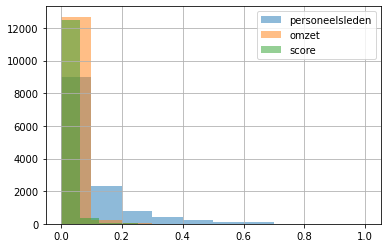

In [43]:
# Visualize data
# plot histogram
from matplotlib import pyplot as plt

dataframe["personeelsleden"].hist(label="personeelsleden", alpha=0.5)
dataframe["omzet"].hist(label="omzet", alpha=0.5)
dataframe["score"].hist(label="score", alpha=0.5)
plt.legend()


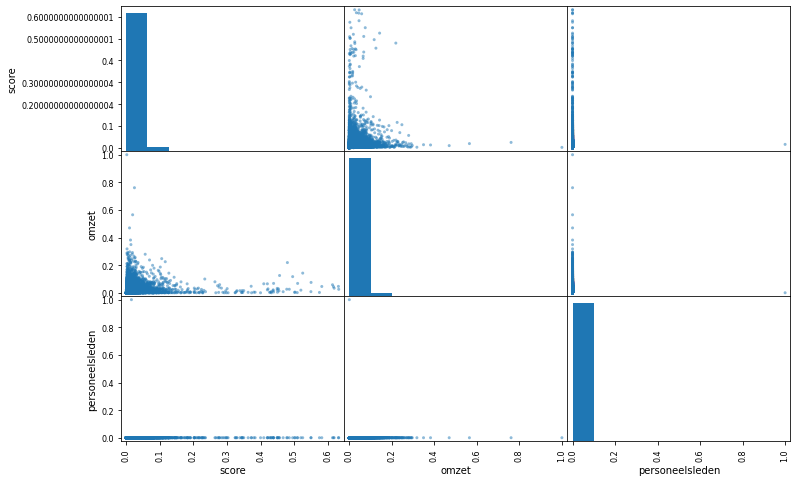

                    omzet  personeelsleden     score
omzet            1.000000        -0.004823  0.095374
personeelsleden -0.004823         1.000000 -0.000019
score            0.095374        -0.000019  1.000000


In [12]:
# plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = dataframe.corr()
corr["score"].sort_values(ascending=False)
from pandas.plotting import scatter_matrix
attributes = ["score", "omzet", "personeelsleden", "beursgenoteerd"]
scatter_matrix(dataframe[attributes], figsize=(12, 8))
plt.show()


print(corr)



In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13002 entries, 0200065765 to 0899993714
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   omzet                   13002 non-null  float64 
 1   beursgenoteerd          13002 non-null  category
 2   sector                  13002 non-null  int32   
 3   personeelsleden         13002 non-null  int32   
 4   hoofdsteden_provincies  13002 non-null  int32   
 5   site_aanwezig           13002 non-null  category
 6   pdf_aanwezig            13002 non-null  category
 7   score                   13002 non-null  float64 
dtypes: category(3), float64(2), int32(3)
memory usage: 495.6+ KB


![white box ml modellen](https://drek4537l1klr.cloudfront.net/thampi/HighResolutionFigures/figure_2-2.png)


In [58]:
# Model schrijven
# ! Kan pas gerund worden vanaf we alle data hebben
X = dataframe.drop(columns=["score"])
y = dataframe["score"]

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# y_train.info()
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 9543 to 7270
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   omzet            11701 non-null  float64 
 1   beursgenoteerd   11701 non-null  category
 2   sector           11701 non-null  category
 3   personeelsleden  11701 non-null  float64 
 4   site_aanwezig    11701 non-null  category
 5   pdf_aanwezig     11701 non-null  category
dtypes: category(4), float64(2)
memory usage: 353.7 KB
<class 'pandas.core.series.Series'>
Int64Index: 1301 entries, 1078 to 4003
Series name: score
Non-Null Count  Dtype  
--------------  -----  
1301 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [59]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TODO:
# - find out what score would be if we always predict the mean and predict 0 + compare with the scores of the models

# Linear Regression
from sklearn.linear_model import LinearRegression
print("------------- Linear Regression --------------")
lin_reg = LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
lin_reg = GridSearchCV(lin_reg, parameters, scoring="neg_mean_squared_error", cv=5)
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
print(f"Best parameters: {lin_reg.best_params_}")
print(f"Best score: {lin_reg.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lin_reg)}")

------------- Linear Regression --------------
Best parameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Best score: -0.0012626740811375152
MSE: 0.001121745309021871


In [15]:


# SVR (Support Vector Regression)
from sklearn.svm import SVR
print("------------- SVR --------------")
svr_regressor = SVR(kernel='rbf', gamma="scale")
parameters = {'C': [1, 10, 20], 'epsilon': [0.1, 0.01, 0.001, 0.0001]}
svr_regressor = GridSearchCV(svr_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)
print(f"Best parameters: {svr_regressor.best_params_}")
print(f"Best score: {svr_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")



# BayesianRidge
from sklearn.linear_model import BayesianRidge
print("------------- BayesianRidge --------------")
bayesian_regressor = BayesianRidge()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
bayesian_regressor = GridSearchCV(bayesian_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
bayesian_regressor.fit(X_train, y_train)
y_pred_bay = bayesian_regressor.predict(X_test)
print(f"Best parameters: {bayesian_regressor.best_params_}")
print(f"Best score: {bayesian_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_bay)}")



------------- SVR --------------
Best parameters: {'C': 20, 'epsilon': 0.01}
Best score: -0.0013316376790261692
MSE: 0.0011853654980451744
------------- BayesianRidge --------------
Best parameters: {'alpha_1': 100, 'alpha_2': 100, 'lambda_1': 100, 'lambda_2': 1}
Best score: -0.0012607776253656957
MSE: 0.0011217683621567954


In [37]:

# LassoLars
from sklearn.linear_model import LassoLars
print("------------- LassoLars --------------")
lassolars_regressor = LassoLars()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lassolars_regressor = GridSearchCV(lassolars_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
lassolars_regressor.fit(X_train, y_train)
y_pred_lassolars = lassolars_regressor.predict(X_test)
print(f"Best parameters: {lassolars_regressor.best_params_}")
print(f"Best score: {lassolars_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lassolars)}")

------------- LassoLars --------------
Best parameters: {'alpha': 0.1}
Best score: -0.0013371472040231932
MSE: 0.001181205935012302


In [38]:
# ARDRegression
from sklearn.linear_model import ARDRegression
print("------------- ARDRegression --------------")
ard_regressor = ARDRegression()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
ard_regressor = GridSearchCV(ard_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ard_regressor.fit(X_train, y_train)
y_pred_ard = ard_regressor.predict(X_test)
print(f"Best parameters: {ard_regressor.best_params_}")
print(f"Best score: {ard_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ard)}")


------------- ARDRegression --------------
Best parameters: {'alpha_1': 0.0001, 'alpha_2': 10, 'lambda_1': 100, 'lambda_2': 1}
Best score: -0.0012607659225271916
MSE: 0.0011208284552682176


In [18]:

# PassiveAggressiveRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
print("------------- PassiveAggressiveRegressor --------------")
passive_regressor = PassiveAggressiveRegressor()
parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'epsilon': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
passive_regressor = GridSearchCV(passive_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
passive_regressor.fit(X_train, y_train)
y_pred_pas = passive_regressor.predict(X_test)
print(f"Best parameters: {passive_regressor.best_params_}")
print(f"Best score: {passive_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_pas)}")


------------- PassiveAggressiveRegressor --------------
Best parameters: {'C': 0.1, 'epsilon': 1}
Best score: -0.0015840646966771455
MSE: 0.0014411840660125688


In [10]:

# TheilSenRegressor
from sklearn.linear_model import TheilSenRegressor
print("------------- TheilSenRegressor --------------")
theil_regressor = TheilSenRegressor()
parameters = {'max_subpopulation': [100, 500, 1000, 5000]}
theil_regressor = GridSearchCV(theil_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
theil_regressor.fit(X_train, y_train)
y_pred_seil = theil_regressor.predict(X_test)
print(f"Best parameters: {theil_regressor.best_params_}")
print(f"Best score: {theil_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_seil)}")



------------- TheilSenRegressor --------------
Best parameters: {'max_subpopulation': 5000}
Best score: -0.001291693628427663
MSE: 0.0011642760387083032


In [12]:
# RANSACRegressor
from sklearn.linear_model import RANSACRegressor
print("------------- RANSACRegressor --------------")
ransac_regressor = RANSACRegressor()
parameters = {'min_samples': [1, 5, 10, 50, 100, 500, 1000], 'max_trials': [100, 500, 1000, 5000]}
ransac_regressor = GridSearchCV(ransac_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ransac_regressor.fit(X_train, y_train)
y_pred_ransac = ransac_regressor.predict(X_test)
print(f"Best parameters: {ransac_regressor.best_params_}")
print(f"Best score: {ransac_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ransac)}")

------------- RANSACRegressor --------------
Best parameters: {'max_trials': 100, 'min_samples': 1000}
Best score: -0.0012766729208790392
MSE: 0.0011168174031129365


In [13]:
# ridge regression
from sklearn.linear_model import Ridge
print("------------- Ridge regression --------------")
ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
print(f"Best parameters: {ridge_regressor.best_params_}")
print(f"Best score: {ridge_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")

# Lasso regression
from sklearn.linear_model import Lasso
print("------------- Lasso regression --------------")
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error", cv=5)
lasso_regressor.fit(X_train, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
y_pred_lasso = lasso_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")


------------- Ridge regression --------------


c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.28566e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.60516e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.00991e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.49635e-18): result may not be accurate.
  return linalg.solve

Best parameters: {'alpha': 1}
Best score: -0.0012607753255567365
MSE: 0.0011213605525535377
------------- Lasso regression --------------
{'alpha': 0.1}
-0.0013228614684309469
MSE: 0.0011819246727523363


In [60]:
from sklearn.metrics import mean_squared_error

# Random forest regression
from sklearn.ensemble import RandomForestRegressor
print("------------- Random forest regression --------------")
random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=5)
# parameters = {'n_estimators': [50, 100, 200, 500, 1000], 'max_depth': [2, 3, 5, 10, 15, 20, 30]}

# random_forest_regressor = GridSearchCV(random_forest_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
random_forest_regressor.fit(X_train, y_train)
# print(random_forest_regressor.best_params_)
# print(random_forest_regressor.best_score_)
y_pred_random = random_forest_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_random)}")
print(f"")

------------- Random forest regression --------------
MSE: 0.0011059401093576008



In [49]:
# R2 scores berekenen voor elk model
from sklearn.metrics import r2_score
print("------------- R2 scores --------------")
print(f"R2 score linear regression: {r2_score(y_test, y_pred_lin_reg)}")
# print(f"R2 score ridge regression: {r2_score(y_test, y_pred_ridge)}")
# print(f"R2 score lasso regression: {r2_score(y_test, y_pred_lasso)}")
# print(f"R2 score passive aggressive regression: {r2_score(y_test, y_pred_pas)}")
# print(f"R2 score theil sen regression: {r2_score(y_test, y_pred_seil)}")
# print(f"R2 score ransac regression: {r2_score(y_test, y_pred_ransac)}")
print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


------------- R2 scores --------------
R2 score linear regression: 0.05098671195104143
R2 score random forest regression: 0.05404407247086129


In [61]:
from sklearn.metrics import r2_score

# print random forest feature importance
importances = random_forest_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_regressor.estimators_],
                axis=0) 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(f"-> {X_train.columns[indices[f]]}")


print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


Feature ranking:
1. feature 0 (0.374718)
-> omzet
2. feature 4 (0.347275)
-> site_aanwezig
3. feature 2 (0.177936)
-> sector
4. feature 3 (0.092873)
-> personeelsleden
5. feature 5 (0.003987)
-> pdf_aanwezig
6. feature 1 (0.003211)
-> beursgenoteerd
R2 score random forest regression: 0.06360162403977576


In [50]:
# get score if model predicted the mean of the training set score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print("------------- Mean score --------------")
mean_score = np.mean(y_train)
print(f"Mean score: {mean_score}")
y_pred_mean = np.full(y_test.shape, mean_score)
print(f"MSE: {mean_squared_error(y_test, y_pred_mean)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_mean)}")
print(f"R2 score: {r2_score(y_test, y_pred_mean)}")

# uhhhh


------------- Mean score --------------
Mean score: 0.015742875521722332
MSE: 0.001181205935012302
MAE: 0.014833374899408074
R2 score: -0.00012587468464064777


In [33]:
# saving the best model
import pickle
filename = 'final_model.sav'
pickle.dump(random_forest_regressor, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

# make a prediction
new_data = X_test.iloc[0]
print([new_data])
print(loaded_model.predict([new_data]))
new_data = [0.00438, 0, 375.0, 0, 0, 1]
print(loaded_model.predict([new_data]))
# shape to 2d array (1, 6)
# loaded_model.predict(np.shape([[0.00438, False, 375.0, 0, 0, 1]], -1))


[omzet              0.00438
beursgenoteerd       False
sector               375.0
personeelsleden          0
site_aanwezig            0
pdf_aanwezig             1
Name: 1078, dtype: object]
[0.00329031]
[0.00329031]


c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [62]:
dataframe


,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,score
0,0.021860,0.0,378.0,0.070175,1,1,0.131380
1,0.029976,1.0,378.0,0.175439,1,1,0.013276
2,0.015178,0.0,13.0,0.438596,0,1,0.003428
3,0.014047,0.0,377.0,0.128655,1,1,0.043966
4,0.025320,0.0,378.0,0.242690,1,1,0.107927
...,...,...,...,...,...,...,...
12997,0.001454,0.0,99.0,0.020468,0,1,0.002817
12998,0.000000,0.0,496.0,0.143275,1,0,0.004862
12999,0.056761,0.0,556.0,0.058480,0,1,0.005119
13000,0.009226,0.0,373.0,0.078947,1,1,0.016008
